In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelBinarizer

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 4627 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
n_classes = len(class_names)
class_names

# label_binarizer = LabelBinarizer()
# image_labels = label_binarizer.fit_transform(class_names)
# print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [5]:
# np_image_list = []
# for image_batch, label_batch in dataset:
#     np_image_list.append(image_batch.numpy().astype('uint8'))

In [6]:
# print("[INFO] Spliting data to train, test")
# x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [7]:
len(dataset)

145

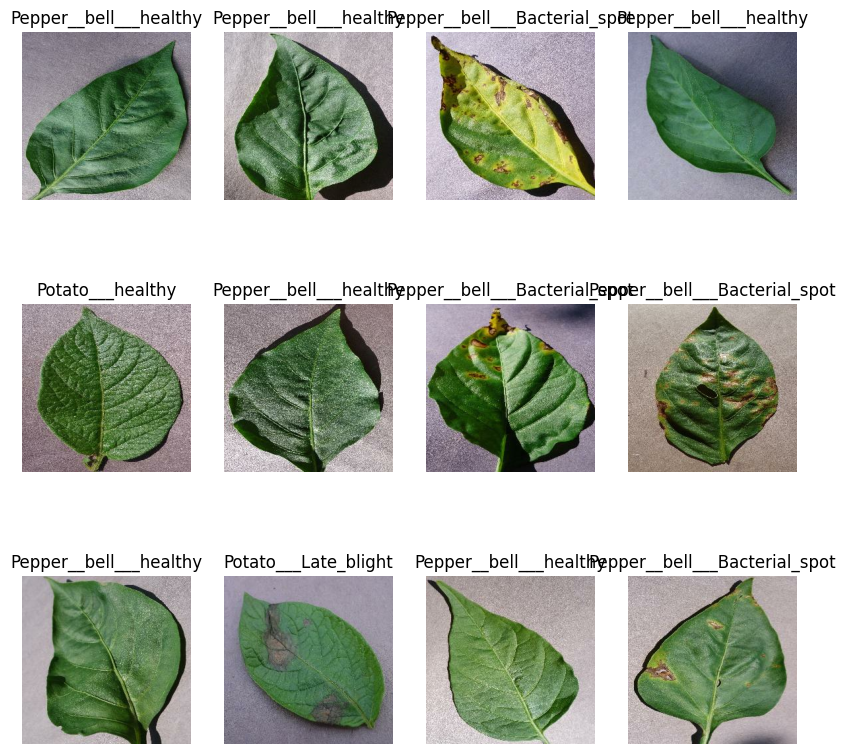

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

145

In [10]:
train_size = 0.8
len(dataset)*train_size

116.0

In [11]:
train_ds = dataset.take(516)
len(train_ds)

145

In [12]:
test_ds = dataset.skip(516)
len(test_ds)

0

In [13]:
len(dataset)*0.1

14.5

In [14]:
val_ds = test_ds.take(64)
len(val_ds)

0

In [15]:
test_ds = test_ds.skip(64)
len(test_ds)

0

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
)

In [96]:
scores = model.evaluate(test_ds)

29/29 [==============================] - 10s 344ms/step - loss: 0.1897 - accuracy: 0.9246


In [97]:
scores

[0.18965521454811096, 0.9245901703834534]

In [98]:
history.history['accuracy']

[0.3987730145454407,
 0.64561527967453,
 0.7820281386375427,
 0.8744135499000549,
 0.9137495756149292]

In [99]:
def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Actual label : Pepper__bell___healthy
Predicted label : Pepper__bell___healthy


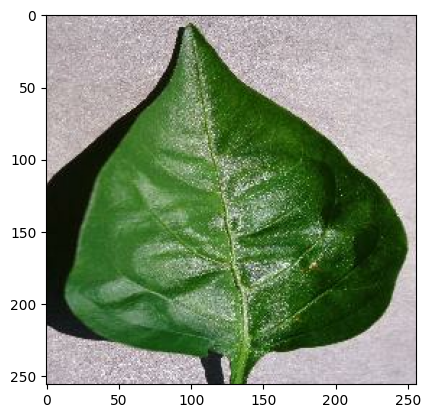

In [100]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print(f"Actual label : {class_names[first_label]}")
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print(f"Predicted label : {class_names[np.argmax(batch_prediction[0])]}")

In [101]:
# model_version=4
# model.save(f"./saved_models/{model_version}")